In [5]:

import datetime
import os
import cv2
import glob
import h5py
import sys
import optparse
import copy

import pylab as pl
from collections import Counter
import seaborn as sns

import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import tifffile as tf

from pipeline.python.classifications import test_responsivity as resp #import calculate_roi_responsivity, group_roidata_stimresponse, find_barval_index
#from pipeline.python.classifications import osi_dsi as osi
#from pipeline.python.visualization import get_session_summary as ss
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.retinotopy import fit_2d_rfs as rf

from pipeline.python.utils import uint16_to_RGB
from skimage import exposure
from matplotlib import patches

from scipy import stats
from scipy.interpolate import interp1d
import scipy.optimize as spopt

In [14]:
%matplotlib notebook

# simulate responses

In [82]:
mean_response = np.random.random(8)
oris = np.linspace(0, 360, 30, endpoint=False)
print(oris)

[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300. 312. 324.
 336. 348.]


In [76]:
np.where(oris==90)

(array([], dtype=int64),)

In [91]:
ori_ix = np.where(oris==60)[0]
ori_ix2 = np.where(oris==(60+180))[0]
print(ori_ix, ori_ix2)

[5] [20]


In [92]:
OSI_cvs = []
DSI_cvs = []
m_responses = []
strength = 10
mean_response = np.random.random(len(oris))
add_response = np.zeros(mean_response.shape)

n_levels = 10
for n_level in range(n_levels):
    add_response[ori_ix] = n_level*strength
    if ori_ix2 is not None:
        add_response[ori_ix2] = n_level*strength / 10
    mean_response = mean_response + add_response
    #mean_response
    #curr_resps = mean_response #fit_results[roi]['mean_responses']
    #curr_oris =  fresults['oris']
    circvar_osi =  np.sum( [r_theta * np.exp(2j*theta) for r_theta, theta in zip(mean_response, oris)] ) / np.sum(mean_response)
    circvar_dsi = np.sum( [r_theta * np.exp(1j*theta) \
                           for r_theta, theta in zip(mean_response, oris)] ) / np.sum(mean_response)
    rOSI_cv = np.abs(circvar_osi) 
    #rOSI_cv = np.abs( np.sum( [r_theta * np.exp(2j*theta) for r_theta, theta in zip(mean_response, oris)] ) / np.sum(mean_response) )
    rDSI_cv = np.abs( circvar_dsi )
    print("strength: %i -- OSI: %.5f, DSI: %.5f" % (strength, rOSI_cv, rDSI_cv))

    OSI_cvs.append(rOSI_cv)
    DSI_cvs.append(rDSI_cv)
    m_responses.append(mean_response)

strength: 10 -- OSI: 0.08671, DSI: 0.03068
strength: 10 -- OSI: 0.33401, DSI: 0.32878
strength: 10 -- OSI: 0.57615, DSI: 0.56134
strength: 10 -- OSI: 0.69976, DSI: 0.67917
strength: 10 -- OSI: 0.76478, DSI: 0.74104
strength: 10 -- OSI: 0.80187, DSI: 0.77632
strength: 10 -- OSI: 0.82468, DSI: 0.79799
strength: 10 -- OSI: 0.83958, DSI: 0.81216
strength: 10 -- OSI: 0.84981, DSI: 0.82188
strength: 10 -- OSI: 0.85711, DSI: 0.82882


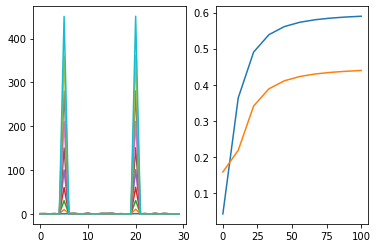

In [85]:
strengths = np.linspace(0, 100, 10)

fig, ax = pl.subplots(1,2)
for r in range(len(m_responses)):
    ax[0].plot(m_responses[r]) # + r*20)
    
ax[1].plot(strengths, OSI_cvs)
ax[1].plot(strengths, DSI_cvs)

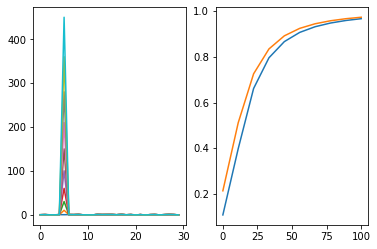

In [88]:
#strengths = np.linspace(0, 100, 10)

fig, ax = pl.subplots(1,2)
for r in range(len(m_responses)):
    ax[0].plot(m_responses[r]) # + r*20)
    
ax[1].plot(strengths, OSI_cvs)
ax[1].plot(strengths, DSI_cvs)

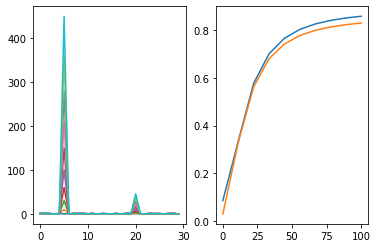

In [93]:
#strengths = np.linspace(0, 100, 10)

fig, ax = pl.subplots(1,2)
for r in range(len(m_responses)):
    ax[0].plot(m_responses[r]) # + r*20)
    
ax[1].plot(strengths, OSI_cvs)
ax[1].plot(strengths, DSI_cvs)

# Load sample data

In [2]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' 
session = '20190522' #'20190319'
fov = 'FOV1_zoom2p0x' 
run = 'combined_gratings_static'
traceid = 'traces001' #'traces002'

data_identifier = '|'.join([animalid, session, fov, run, traceid])

create_new=True
n_processes=1

In [3]:
traceid_dir =  glob.glob(os.path.join(rootdir, animalid, session, fov, run, 'traces', '%s*' % traceid))[0]
data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', 'datasets.npz'))[0]
dset = np.load(data_fpath)

data_identifier = '|'.join([animalid, session, fov, run, traceid])


raw_traces = pd.DataFrame(dset['corrected'])
#dff_traces = pd.DataFrame(dset['dff'])
labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
sdf = pd.DataFrame(dset['sconfigs'][()]).T

fr = 44.65 #dset['run_info'][()]['framerate']
nframes_on = labels['nframes_on'].unique()[0]
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_post_onset = nframes_on + int(round(1.*fr))


In [4]:
#gdf = resp.group_roidata_stimresponse(raw_traces.values, labels) # Each group is roi's trials x metrics
gdf = resp.get_roi_response_by_trial(raw_traces.values, labels)
#gratings_df_by_rois.get_group(roi_list[0])
nrois_total = len(gdf.groups)



#### Filter cells by responsivity

In [408]:
metric_type = 'dff'
metric_thr = 0.5
goodness_type = ['zscore'] #['zscore', 'snr']
goodness_thr = [4] # [1.5, 1.5]


roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[metric_type].max() >= metric_thr\
            and g.groupby(['config']).mean()[goodness_type[0]].max() >= goodness_thr[0] ] 

print("%i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total, metric_type, metric_thr))

goodness_str = '_'.join(['%s%.2f' % (gt, gthr) for gt, gthr in zip(goodness_type, goodness_thr)])

fit_str = 'responsemin_%s%.2f_goodness_%s' % (metric_type, metric_thr, goodness_str)


5 out of 260 cells meet min dff req. of 0.50


In [409]:
# Create output dir

In [410]:

#roi_fitdir = os.path.join(traceid_dir, 'figures', 'fits', 'tuning_by_roi_%s' % response_type)
desc_str = 'Liang2018_Andermann'
roi_fitdir = os.path.join(traceid_dir, 'figures', 'tuning', 'fit_%s_%s' % (response_type, fit_str), desc_str)

if not os.path.exists(roi_fitdir):
    os.makedirs(roi_fitdir)
print("Saving roi fits to: %s" % roi_fitdir)

Saving roi fits to: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/figures/tuning/fit_zscore_responsemin_dff0.50_goodness_zscore4.00/Liang2018_Andermann


# Bootstrap responses

In [411]:
def group_configs(group, response_type):
    config = group['config'].unique()[0]
    group.index = np.arange(0, group.shape[0])

    return pd.DataFrame(data={'%s' % config: group[response_type]})

In [412]:
def get_init_params(response_vector):
    theta_pref = response_vector.idxmax()
    theta_null = (theta_pref + 180) % 360.
    r_pef = bootstrapped_df
    r_pref = response_vector.loc[theta_pref]
    r_null = response_vector.loc[theta_null]
    sigma = np.mean(np.diff([response_vector.index.tolist()]))
    non_prefs = [t for t in response_vector.index.tolist() if t not in [theta_pref, theta_null]]
    r_offset = np.mean([response_vector.loc[t] for t in non_prefs])
    return r_pref, r_null, theta_pref, sigma, r_offset

In [413]:

#%
def angdir180(x):
    '''wraps anguar diff values to interval 0, 180'''
    return min(np.abs([x, x-360, x+360]))

def double_gaussian( x, c1, c2, mu, sigma, C ):
    #(c1, c2, mu, sigma) = params
    x1vals = np.array([angdir180(xi - mu) for xi in x])
    x2vals = np.array([angdir180(xi - mu - 180 ) for xi in x])
    res =   C + c1 * np.exp( - x1vals**2.0 / (2.0 * sigma**2.0) ) \
            + c2 * np.exp( - x2vals**2.0 / (2.0 * sigma**2.0) )

#    res =   C + c1 * np.exp( - ((x - mu) % 360.)**2.0 / (2.0 * sigma**2.0) ) \
#            + c2 * np.exp( - ((x + 180 - mu) % 360.)**2.0 / (2.0 * sigma**2.0) )

#        res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) \
#                #+ c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

In [414]:
def fit_direction_selectivity(x, y, init_params=[0, 0, 0, 0, 0], bounds=[np.inf, np.inf, np.inf, np.inf, np.inf]):
    roi_fit = None
    
    popt, pcov = spopt.curve_fit(double_gaussian, x, y, p0=init_params, maxfev=1000, bounds=bounds)
    fitr = double_gaussian( x, *popt)
        
    # Get residual sum of squares 
    residuals = y - fitr
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    if pcov.max() == np.inf: # or r2 == 1: #round(r2, 3) < 0.15 or 
        success = False
    else:
        success = True
        
    if success:
        roi_fit = {'pcov': pcov,
                     'popt': popt,
                     'fit_y': fitr,
                     'r2': r2,
                     #'x': x,
                     #'y': y,
                     'init': init_params,
                     'success': success}
    return roi_fit


In [415]:

def interp_values(response_vector, n_intervals=3, wrap_value=None):
    resps_interp = []
    resps = copy.copy(response_vector)
    if wrap_value is not None:
        resps = np.append(response_vector, wrap_value)
    for orix, resp in enumerate(resps[0:-1]):
        if resp == resps[-2]:
            resps_interp.extend(np.linspace(resp, resps[orix+1], endpoint=True, num=n_intervals+1))
        else:
            resps_interp.extend(np.linspace(resp, resps[orix+1], endpoint=False, num=n_intervals))          
    return resps_interp

In [416]:
def get_ASI(response_vector, thetas):
    asi = np.abs( np.sum( [theta_resp * np.exp((2j*2*np.pi*theta_val) / (2*np.pi)) \
                 for theta_resp, theta_val in zip(response_vector, thetas)] ) ) / np.sum(np.abs(response_vector))
    return asi

def get_DSI(response_vector, thetas):
    dsi = np.abs( np.sum( [theta_resp * np.exp((1j*2*np.pi*theta_val) / (2*np.pi)) \
                 for theta_resp, theta_val in zip(response_vector, thetas)] ) ) / np.sum(np.abs(response_vector))
    return dsi

In [417]:


def cleanup_axes(axes_list, which_axis='y'):    
    for ax in axes_list: 
        if which_axis=='y':
            # get the yticklabels from the axis and set visibility to False
            for label in ax.get_yticklabels():
                label.set_visible(False)
            ax.yaxis.offsetText.set_visible(False)
        elif which_axis=='x':
            # get the xticklabels from the axis and set visibility to False
            for label in ax.get_xticklabels():
                label.set_visible(False)
            ax.xaxis.offsetText.set_visible(False)


In [418]:
tested_oris = sdf['ori'].unique()
print(tested_oris)
oris_interp = interp_values(tested_oris, n_intervals=3, wrap_value=360)

[0 45 90 135 180 225 270 315]


In [419]:
response_type = 'zscore'
n_bootstrap_iters = 100
n_intervals_interp = 3


<IPython.core.display.Javascript object>


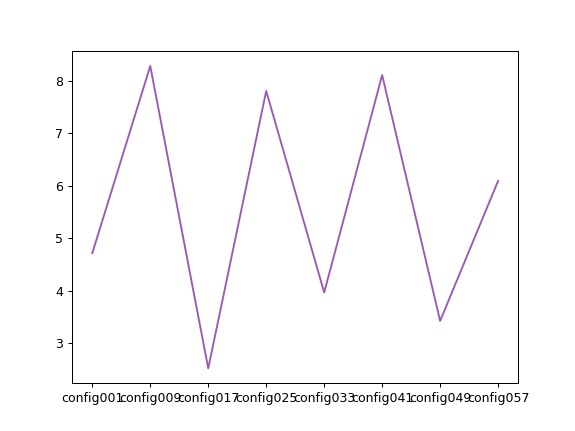

In [420]:
pl.figure();
pl.plot(responses_df.mean(axis=0))

In [422]:
constant_params = ['aspect', 'luminance', 'position', 'stimtype']
params = [c for c in sdf.columns if c not in constant_params]
stimdf = sdf[params]
    
roi_fits = []
for roi in roi_list: #[30, 91, 93, 151]:
    print(roi)
    roi_df = gdf.get_group(roi)

    mean_responses = roi_df.groupby(['config']).mean()[response_type]
    sem_responses = roi_df.groupby(['config']).sem()[response_type]
    sorted_config_ixs = mean_responses.values.argsort()[::-1]
    sorted_configs = [mean_responses.index[s] for s in sorted_config_ixs]
    
    # Find best config:
    best_cfg = sorted_configs[0]
    best_cfg_params = stimdf.loc[best_cfg][[p for p in params if p!='ori']]
    curr_cfgs = sorted([c for c in stimdf.index.tolist() \
                        if all(stimdf.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
                        key = lambda x: stimdf['ori'][x])

    # Get all trials of current set of cfgs:
    trialdf = roi_df[roi_df['config'].isin(curr_cfgs)]
    rdf = trialdf[['config', 'trial', response_type]]
    grouplist = [group_configs(group, response_type) for config, group in rdf.groupby(['config'])]
    responses_df = pd.concat(grouplist, axis=1)

    # Bootstrap distN of responses (rand w replacement):
    bootdf = [responses_df.sample(60, replace=True).mean(axis=0) for ni in range(n_bootstrap_iters)]
    bootstrapped_df = pd.concat(bootdf, axis=1)
    bootstrapped_df.index = [sdf['ori'][c] for c in bootstrapped_df.index]

    # Find init params for tuning fits and set fit constraints:
    init_params = get_init_params(bootstrapped_df[0])
    r_pref, r_null, theta_pref, sigma, r_offset = init_params
    init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

    # Interpolate values for finer steps:
    asi=[];dsi=[];r2=[];
    for niter in bootstrapped_df.columns:
        oris_interp = interp_values(tested_oris, n_intervals=n_intervals, wrap_value=360)
        resps_interp = interp_values(bootstrapped_df[niter], n_intervals=n_intervals_interp, \
                                     wrap_value=bootstrapped_df[niter][0])


        init_params = get_init_params(bootstrapped_df[niter])
        r_pref, r_null, theta_pref, sigma, r_offset = init_params
        init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])
        
        fail = False
        try:
            rfit = fit_direction_selectivity(oris_interp, resps_interp, init_params, bounds=init_bounds)
            asi_t = get_ASI(rfit['fit_y'][0:-1], oris_interp[0:-1])
            dsi_t = get_DSI(rfit['fit_y'][0:-1], oris_interp[0:-1])

            asi.append(asi_t)
            dsi.append(dsi_t)
            r2.append(rfit['r2'])
        except Exception as e:
            print(e)
            fail = True
            print("... skipping %i" % roi)
            break
        
    if not fail:
        roi_fits.append(pd.DataFrame({'ASI': asi,
                                      'DSI': dsi,
                                      'r2': r2,
                                      'cell': [roi for _ in np.arange(0, len(asi))]}))

    
    #print("[%i] ASI: %.3f (+/- %.3f), DSI: %.3f (+/- %.3f) (bootstrap %i iter)" % (roi, np.mean(asi), np.std(asi), np.mean(dsi), np.std(dsi), n_bootstrap_iters))


30
75
151
163
234


In [423]:
fitdf = pd.concat(roi_fits, axis=0)
fitdf.head()
fitdf['cell'] = fitdf['cell'].astype('category')

In [424]:
fitdf.dtypes

ASI      float64
DSI      float64
cell    category
r2       float64
dtype: object

In [425]:
fitdf['ASI'].max()

0.099136850728580223

In [426]:
fitdf.head()

,ASI,DSI,cell,r2
0,0.071791,0.009880,30,0.979653
1,0.072461,0.010076,30,0.984009
2,0.071922,0.010960,30,0.982966
3,0.072596,0.011589,30,0.979689
4,0.071439,0.011110,30,0.982511


<IPython.core.display.Javascript object>


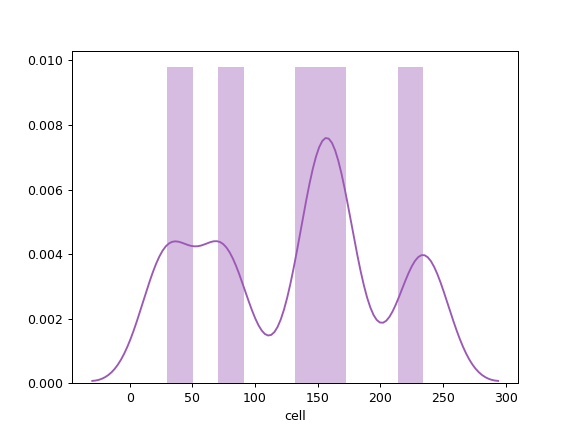

In [427]:
pl.figure()
sns.distplot(fitdf['cell'])

<IPython.core.display.Javascript object>


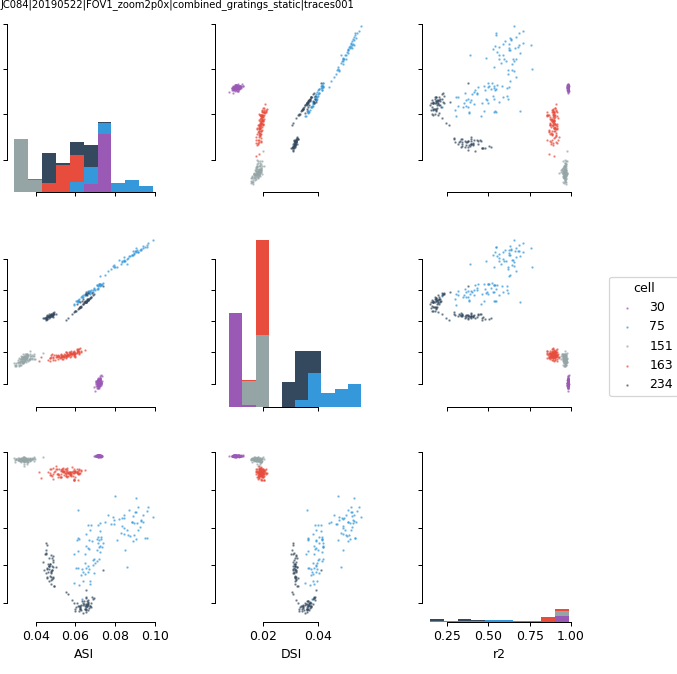

In [430]:
g = sns.PairGrid(fitdf, hue='cell', vars=['ASI', 'DSI', 'r2'])
g = g.map_offdiag(pl.scatter, marker='o',  alpha=0.5, s=1)

g = g.map_diag(pl.hist, normed=True) #histtype="step",  

#sns.distplot, kde=False, hist=True, rug=True,\
               #hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})
g = g.add_legend(bbox_to_anchor=(1.01,.5))

pl.subplots_adjust(left=0.01, right=0.85)
sns.despine(trim=True)

cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
cleanup_axes( g.axes[:-1, :].flat, which_axis='x')

label_figure(g.fig, data_identifier)

figname = 'distN_ASI_DSI_bootstrap%i' % n_bootstrap_iters
pl.savefig(os.path.join(roi_fitdir, '%s.png' % figname))
#pl.close()



In [428]:
g = sns.PairGrid(fitdf, hue='cell') #, vars=['ASI', 'DSI', 'r2'])
        g = g.map_offdiag(pl.scatter, marker='+')

    
g = g.map_diag(sns.distplot, kde=False, hist=True, rug=True,\
               hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})

IndentationError: unexpected indent (<ipython-input-428-11100b69308e>, line 2)

In [429]:

g = sns.PairGrid(fitdf, hue='cell', vars=['ASI', 'DSI', 'r2'])

g = g.map_diag(sns.distplot, kde=False, hist=True, rug=True,\
               hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})
g = g.map_offdiag(pl.scatter, marker='+')

g.set(xlim=(0,1), ylim=(0,1))
g.set(xticks=[0, 1])
g.set(yticks=[0, 1])
sns.despine(trim=True)

cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
cleanup_axes( g.axes[:-1, :].flat, which_axis='x')



<IPython.core.display.Javascript object>

TypeError: 'numpy.int64' object is not iterable

<IPython.core.display.Javascript object>


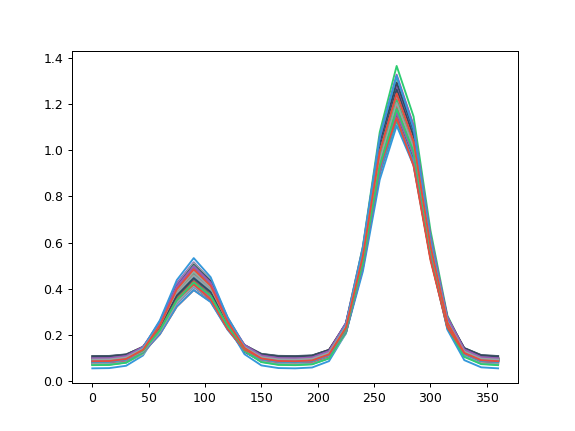

In [176]:
fig, ax = pl.subplots()
for br in bootstrapped_fits:
    ax.plot(oris_interp, br['fit_y'])

In [166]:
asi = get_ASI(rfit['fit_y'], oris_interp)
dsi = get_DSI(rfit['fit_y'], oris_interp)
print("ASI: %.2f, DSI: %.2f" % (asi, dsi))

ASI: 0.07, DSI: 0.01


In [32]:
x = rdf.groupby(['config']).apply(group_configs, response_type)


ValueError: Plan shapes are not aligned

In [30]:
x.shape

(1240, 1)

In [25]:
pd.DataFrame(data=rdf.groupby(['config'])['dff'].apply(np.array).values)

,0
0,"[0.197346476826, 0.0189041892801, 0.1106356293..."
1,"[0.336630562764, 0.475683342706, 0.47338181193..."
2,"[0.0508394282838, 0.0627176877596, 0.019022855..."
3,"[0.122029687788, 0.662941280718, 0.46299090975..."
4,"[0.334152229015, -0.117570336881, -0.080865504..."
5,"[0.132585848871, 0.108803858515, 0.22346681209..."
6,"[0.415117818805, 0.11178881399, 0.231719181844..."
7,"[-0.034004940764, 0.45328845876, 0.53898263135..."
8,"[-0.185469417564, -0.0446771156282, 0.02680228..."
9,"[0.529325203276, 0.292090651618, 0.37291062689..."
